## Getting back to Bayesics: using Bayesian inference to better understand the Global Terror Database

### Brief Introduction

The Global Terrorism Database (GTD) is a product of several years of work collating, classifying, and recording terrorist attacks around the world in the years between 1970 and 2015 by several different organizations. The GTD has been housed at the University of Maryland since 2011 and the team there have developed standardized modes of collectiona and recording information, but unfortunately, a vast amount of the pre-2011 data suffers from issues relating to multiple compilers. This includes several missing variables for years prior to 1997, vague responses to certain issues (including things like group name, or whether or not the attacks were claimed by a group), and most famously: no incidents whatsoever for the year of 1993.

### Problem Statement

Given this fact, my class worked towards first applying Bayesian inference to an area of interest within the dataset, and then trying to model a simple way to calculate (roughly) how many bombings there might have been in 1993.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')

% matplotlib inline

In [2]:
df = pd.read_csv('../../../globalterrorismdb_0616dist.csv')

/Users/rb/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4,61,62,66,116,117,123) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#OK, what does the dataset look like
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,...,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,0,0,NaN,0,NaN,58,Dominican Republic,2,...,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,...,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
4,197001000003,1970,1,0,NaN,0,NaN,101,Japan,4,...,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN


## EDA

In [4]:
#run a quick EDA on this to look to see what 
def eda(dataframe):
    print "missing values \n", dataframe.isnull().sum()
    print "dataframe index \n", dataframe.index
    print "dataframe types \n", dataframe.dtypes
#     print "dataframe shape \n", dataframe.shape
#     print "dataframe describe \n", dataframe.describe()
    for item in dataframe:
        print item
        print dataframe[item].nunique()

eda(df)

#there are a tonne of nulls, but it may be worth keeping them in the dataframe just to make sure we don't lose any information
#there's 206 unique countries and 3290 groups represented in the dataset!

missing values 
eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            152016
extended                   0
resolution            153270
country                    0
country_txt                0
region                     0
region_txt                 0
provstate              14520
city                     446
latitude                4519
longitude               4519
specificity                0
vicinity                   0
location              114561
summary                66140
crit1                      0
crit2                      0
crit3                      0
doubtterr                  1
alternative           132536
alternative_txt            0
multiple                   0
success                    0
suicide                    0
attacktype1                0
attacktype1_txt            0
                       ...  
propextent            100420
propextent_txt             0
propvalue             12546

In [5]:
df.shape

(156772, 137)

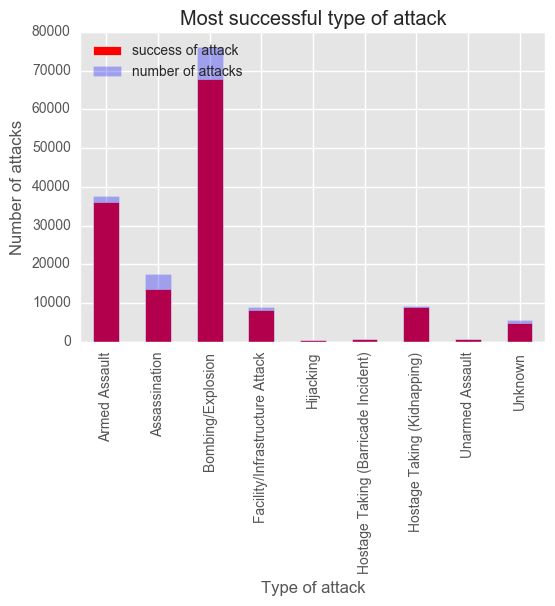

In [6]:
#let's take a quick look at the distribution of successful attacks by attack type
df.groupby('attacktype1_txt').success.sum().plot(kind='bar', color='r', label='success of attack')
df.groupby('attacktype1_txt').eventid.count().plot(kind='bar', color='b', label='number of attacks', alpha=0.3)
plt.legend(loc='upper left')
plt.title("Most successful type of attack")
plt.ylabel("Number of attacks")
plt.xlabel("Type of attack")
#looks like bombing/explosions are the most successful types of attacks, which makes sense given the number of attacks
#on the other hand, it looks like bombings on average are LESS successful than armed assault or hostage takings.

#success is defined by tangible effects vs. whether the goal of the perpetrator was met


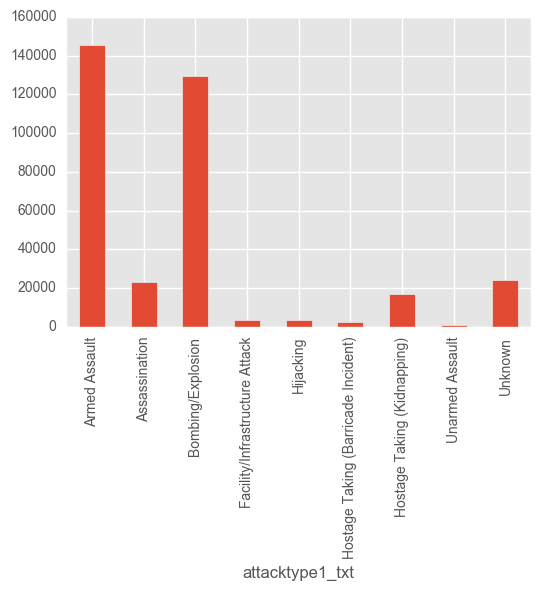

In [7]:
#hm, it also looks like armed assaults actually kill more people than bombs which is surprising given there are more
#bombings recorded
df.groupby('attacktype1_txt').nkill.sum().plot(kind='bar')

## Working with data on bombings

In [8]:
#Okay, so we're working with bombs. Let's create a dataset that only includes instances classed as bombings
dfb = df[df.attacktype1 == 3]

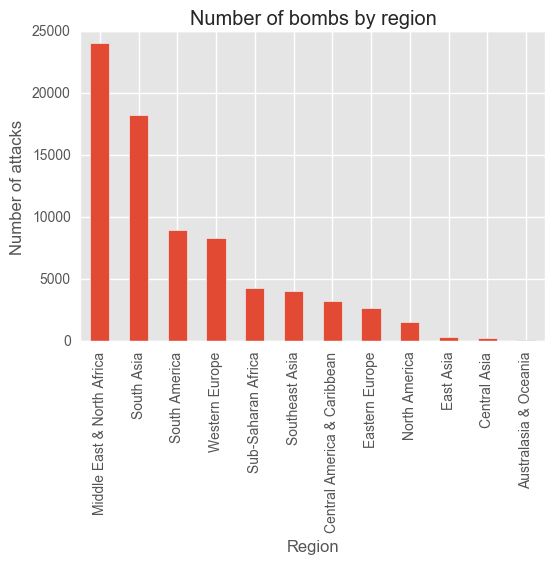

In [9]:
#OK, and how are these distributed by region
dfb.region_txt.value_counts().plot(kind="bar")
plt.title("Number of bombs by region")
plt.xlabel("Region")
plt.ylabel("Number of attacks")
#Unsurprised about MENA TBH

In [10]:
#HM, I wonder if there was a difference in distribution before and after 1993
dfb_1993 = dfb[dfb.iyear < 1993]

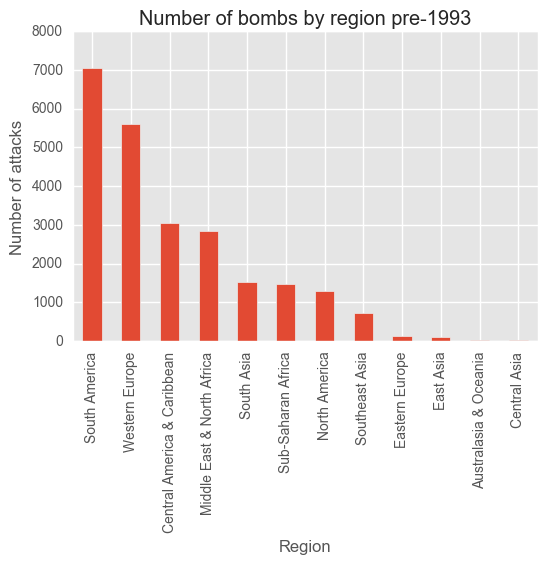

In [11]:
dfb_1993.region_txt.value_counts().plot(kind="bar")
plt.title("Number of bombs by region pre-1993")
plt.xlabel("Region")
plt.ylabel("Number of attacks")
#South America and Western Europe seeing the effects of SL, FARC, IRA, and ETA there

In [12]:
#and how about another one going through 2003 (when there would have been an uptick in number of attacks following
#the Iraq and Afghan wars)
dfb_2000 = dfb[(dfb.iyear > 1993) & (dfb.iyear <= 2003)]

In [13]:
#and a third after
dfb_2015 = dfb[dfb.iyear > 2003]

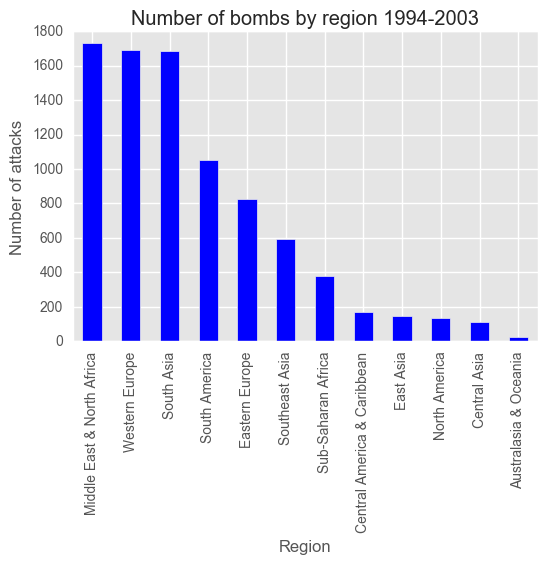

In [14]:
dfb_2000.region_txt.value_counts().plot(kind='bar', color='b')
plt.title("Number of bombs by region 1994-2003")
plt.xlabel("Region")
plt.ylabel("Number of attacks")
#Here's where MENA, Western Europe, and South Asia all have similarly high numbers of attacks. I'll venture a guess
#and say that the sudden rise in South Asia is the LTTE and the growth of separatists movements through India.
#ETA and IRA (or Real IRA at this point) are probably also key players in Western Europe through 1997 or so

In [15]:
#just to take a quick look:
#India, Sri Lanka, Pakistan all seeing a large number of attacks which explains the increase in S Asian attacks that
#I'd guessed at above
dfb_2000.country_txt.value_counts().head(20)

Colombia                    775
India                       767
France                      632
Algeria                     496
Russia                      403
United Kingdom              363
Spain                       361
Turkey                      359
Sri Lanka                   295
Pakistan                    259
Philippines                 237
Lebanon                     216
Israel                      210
West Bank and Gaza Strip    168
Indonesia                   163
Bangladesh                  157
Greece                      151
Afghanistan                 140
Iraq                        133
Peru                        109
Name: country_txt, dtype: int64

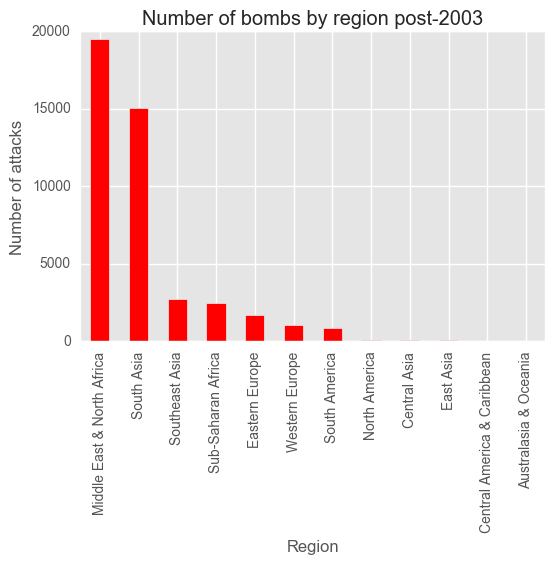

In [16]:
#And a last one to look at post-2003
dfb_2015.region_txt.value_counts().plot(kind='bar', color='r')
plt.title("Number of bombs by region post-2003")
plt.xlabel("Region")
plt.ylabel("Number of attacks")
#sigh. Yep. As expected.

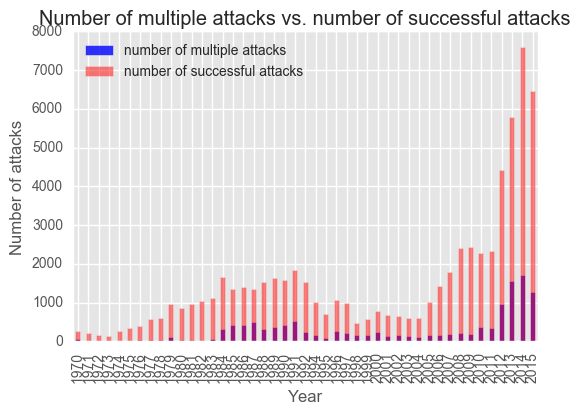

In [17]:
#HYPOTHESIS TESTING:
#Are multiple attacks successful in general
dfb.groupby('iyear').multiple.sum().plot(kind="bar", color='b', label='number of multiple attacks', alpha=0.8)
dfb.groupby('iyear').success.sum().plot(kind='bar', color='r', label='number of successful attacks', alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Number of multiple attacks vs. number of successful attacks')
#WELL MAYBE

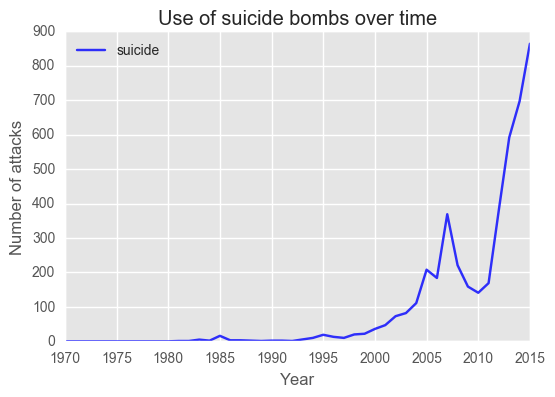

In [18]:
#And how has the use of suicide bombs changed over time?
dfb.groupby('iyear').suicide.sum().plot(kind="line", color='b', alpha=0.8)
# dfb.groupby('iyear').claimed.sum().plot(kind="line", color='r', alpha=0.8)
# dfb.groupby('suicide').nkill.sum().plot(kind='bar', color='r', label='success of attacks', alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Use of suicide bombs over time')

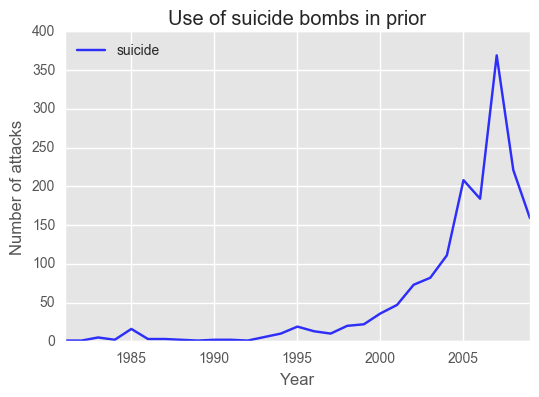

In [25]:
dfb_s_prior.groupby('iyear').suicide.sum().plot(kind="line", color='b', alpha=0.8)
# dfb.groupby('iyear').claimed.sum().plot(kind="line", color='r', alpha=0.8)
# dfb.groupby('suicide').nkill.sum().plot(kind='bar', color='r', label='success of attacks', alpha=0.5)
plt.legend(loc='upper left')
plt.xlabel('Year')
plt.ylabel('Number of attacks')
plt.title('Use of suicide bombs in prior')

In [20]:
#OK, which groups MOST use suicide bombs?
dfb.groupby('gname').suicide.sum().sort_values(ascending=False).head(30)
#Well, that explains the spike in 2013 (that's when ISIL was formed)

gname
Unknown                                                  1902
Taliban                                                   521
Islamic State of Iraq and the Levant (ISIL)               517
Boko Haram                                                219
Tehrik-i-Taliban Pakistan (TTP)                           124
Al-Qaida in Iraq                                          122
Liberation Tigers of Tamil Eelam (LTTE)                    99
Al-Qaida in the Arabian Peninsula (AQAP)                   96
Al-Shabaab                                                 86
Al-Nusrah Front                                            65
Hamas (Islamic Resistance Movement)                        62
Haqqani Network                                            39
Al-Aqsa Martyrs Brigade                                    36
Palestinian Islamic Jihad (PIJ)                            35
Al-Qaida in the Islamic Maghreb (AQIM)                     30
Islamic State of Iraq (ISI)                                27
Ch

In [21]:
#and which groups have the most successful attacks?
dfb.groupby('gname').success.sum().sort_values(ascending=False).head(30)

gname
Unknown                                                        35521
Taliban                                                         2230
Shining Path (SL)                                               2030
Islamic State of Iraq and the Levant (ISIL)                     1755
Farabundo Marti National Liberation Front (FMLN)                1394
Basque Fatherland and Freedom (ETA)                             1026
Irish Republican Army (IRA)                                      963
Revolutionary Armed Forces of Colombia (FARC)                    801
Al-Shabaab                                                       699
Liberation Tigers of Tamil Eelam (LTTE)                          619
Manuel Rodriguez Patriotic Front (FPMR)                          607
Corsican National Liberation Front (FLNC)                        577
Tehrik-i-Taliban Pakistan (TTP)                                  534
National Liberation Army of Colombia (ELN)                       529
Boko Haram                  

In [22]:
#How about the LEAST successful?
dfb.groupby('gname').success.sum().sort_values(ascending=False).tail(30)
#there's a typo in this dataset that's been driving me crazy this past week. That should be Striking MINERS Group, not
#Striking Minors Group.
#Support of Ocalan-The Hawks of Thrace is a great name though.

gname
Striking Minors Group                            0
Sudurpaschim Janata Dal                          0
Support of Ocalan-The Hawks of Thrace            0
Al-Qaida in the Indian Subcontinent              0
Izberbash Gang                                   0
Islamic Mujahidin                                0
Tawhid and Jihad (Palestine)                     0
Druzes                                           0
Terai Communist Party                            0
Al-Ma'unah                                       0
Dawn Forces                                      0
All Ethiopian Unity Party (AEUP)                 0
Communist Guerilla Nuclei                        0
Skinheads                                        0
Last Alternative Guerrilla Front                 0
Revolutionary Military Council                   0
Revolutionary Movement                           0
Communist Party of Nepal (People's War Group)    0
Anti-Capitalist Action                           0
S. O. S. France          

### Bayesian Inference

After having delved into the data, I decided to use Bayesian inference to look at groups that engage in suicide bombing attacks. Our dataset becomes quite small when narrowing our focus down to such an extent, which means a Bayesian approach is more useful as Bayesian analysis does not assume larger sample sizes in its approach, allowing us to determine credible parameter values given our observed data (unlike the frequentist approach which tell us that, if we were to run our test a 100 times, our results would fall within a given range of values 95% of the time, rather than telling us what we need to know about the data at hand). 

"Bayesian analysis determines what can be inferred about parameter values given the actually observed data. Bayesian analysis is the mathematically normative way to reallocate credibility across parameter values as new data arrive." (_The Time Has Come_: John K. Kruschke, Herman Aguinis, Harry Joo) 

To understand the data, I set my prior to be pre-2010 attacks, with the goal of revising my parameters given what I could observe about Taliban and Al-Qaida attacks in the post-2010 years. This is an informed prior (right???)

2010 proves to be an interesting cut off point to examine the distribution of suicide bombs, as they were being used less frequently than prior years between 2008, 2009, and 2010 for a variety of reasons (changes in the Iraq and Afghan wars were the biggest point here as Iraq was making up a majority of the cases in the years immediately prior. A lot of the larger separatist movements around the world who use suicide attacks were also laying down arms around this point--LTTE admitted defeat in 2009, for example, and the Chechen rebels and Maoist separatists in Central India had not had a large-scale operation since the mid-2000s.)

Having plotted my posteriors, the difference of means falls outside the credible parameters, allowing us to infer that the Taliban and Al-Qaida's frequency of suicide bomb use is statistically different.

Our difference of means is actually pretty close to our prior mean, but adjusting the standard deviation to a lower range (perhaps the credible parameters generated) may be useful when adjusting the prior. I also just took ALL instances of a group with Al-Qaida in the title and Taliban in the title. Given there are branches of both that have not really been successful in any of their attacks, it may interesting to compare two different Al-Qaida groups or two different Taliban groups.

In [23]:
#let's set up a new dataframe with suicide bombs only
dfb_s = dfb[(dfb.suicide==1)]

In [24]:
#now setting a new dataframe JUST for prior
dfb_s_prior = dfb_s[(dfb_s.iyear < 2010)]

In [26]:
#and another for the populations of interest
dfb_s_y = dfb_s[dfb_s.iyear >= 2010]

In [27]:
#IMPORTING THINGS!!!!
import pymc3 as pm
import pydot

Couldn't import dot_parser, loading of dot files will not be possible.


In [28]:
#Let's set our populations of interest
Taliban = dfb_s_y[dfb_s_y.gname.str.contains('Taliban')].iyear.value_counts().values
Al_Qaida = dfb_s_y[dfb_s_y.gname.str.contains("Al-Qaida")].iyear.value_counts().values

In [29]:
#AND NOW LET'S SET SOME PRIORS
mean_prior_mean = dfb_s_prior.iyear.value_counts().mean()
mean_prior_std = dfb_s_prior.iyear.value_counts().std()

In [30]:
print mean_prior_mean
print mean_prior_std
#a standard deviation sounds silly but who am I to argue with the data

57.9642857143
90.9087789196


In [31]:
#INSTANTIATE MODEL
with pm.Model() as model:

    t_mean = pm.Normal('attacks_t_mean', mean_prior_mean, sd=mean_prior_std)
    aq_mean = pm.Normal('attacks_aq_mean', mean_prior_mean, sd=mean_prior_std)


In [32]:
std_prior_lower = 0.01
std_prior_upper = 100.0

with model:
    
    t_std = pm.Uniform('attacks_t_std', lower=std_prior_lower, upper=std_prior_upper)
    aq_std = pm.Uniform('attacks_aq_std', lower=std_prior_lower, upper=std_prior_upper)


In [33]:
#I tried this out with a Poisson distribution and with a Gamma distribution, but looks like the normal makes the most sense
with model:

    grpt = pm.Normal('group_t', mu=t_mean, sd=t_std, observed=Taliban)
    grpaq = pm.Normal('group_aq', mu=aq_mean,sd=aq_std, observed=Al_Qaida)



In [34]:
with model:

    diff_of_means = pm.Deterministic('difference of means', t_mean - aq_mean)
    diff_of_stds = pm.Deterministic('difference of stds', t_std - aq_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((t_std**2 + aq_std**2) / 2))

In [35]:
with model:
    trace = pm.sample(20000, njobs=4)


Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average ELBO = -63.819: 100%|██████████| 200000/200000 [00:14<00:00, 13602.46it/s]
Finished [100%]: Average ELBO = -63.713
100%|██████████| 20000/20000 [01:18<00:00, 254.52it/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x142662a50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1427a55d0>], dtype=object)

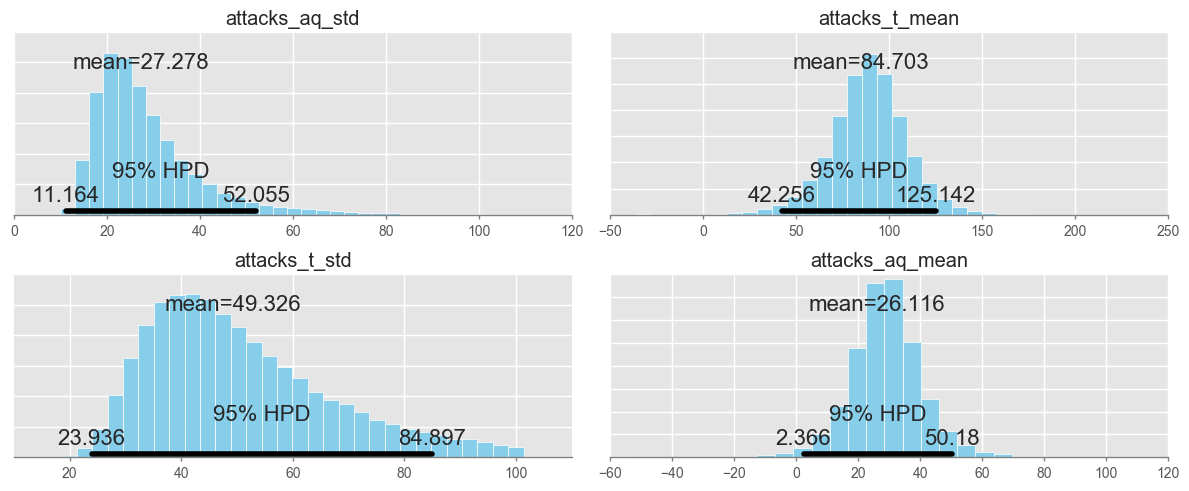

In [36]:
pm.plot_posterior(trace[3000:],
                  varnames=['attacks_t_mean', 'attacks_aq_mean', 'attacks_t_std', 'attacks_aq_std'],
                  color='#87ceeb')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x142447690>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x142eee690>], dtype=object)

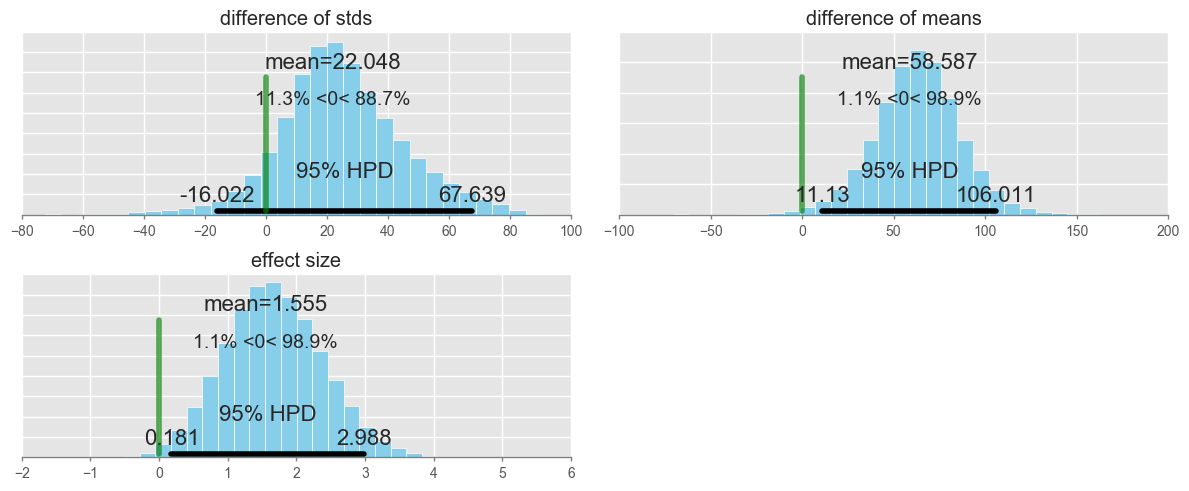

In [37]:
#so Taliban and AQ are statistically different groups--which, good to confirm--and the mean effect size is 1.562
pm.plot_posterior(trace[3000:],
                  varnames=['difference of means', 'difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb')

In [38]:
pm.summary(trace[3000:],
           varnames=['difference of means', 'difference of stds', 'effect size'])



difference of means:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  58.587           23.614           0.134            [11.130, 106.011]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  10.070         44.111         58.937         73.489         105.141


difference of stds:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  22.048           20.453           0.170            [-16.022, 67.639]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  -18.569        9.601          20.767         34.232         65.621


effect size:

  Mean             SD               MC Error         95

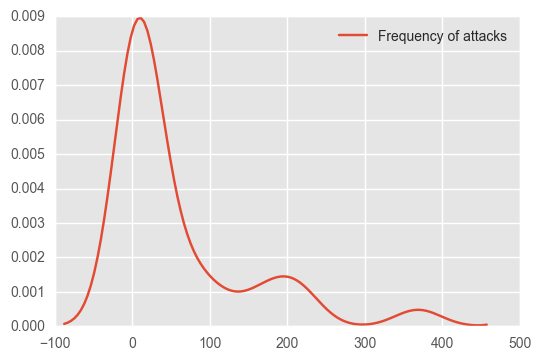

In [39]:
sns.kdeplot(dfb_s_prior.iyear.value_counts(), label='Frequency of attacks')


## Interpretation

What we're getting from this--this being the statistically different means where the overlap between means doesn't fall within the credible intervals--is that the Taliban and Al-Qaida are statistically different groups. Statistically different makes sense, given that they are just that, 

## Predicting 1993

To predict the rough number of bombing attacks in 1993, I used a rolling mean to predict what values were likely for 1993, given the values in prior years as well as a few years following 1993, and allowing for errors and adjustments over a period prior. This allowed me to account for changes in trend lines between 1970 and 1991, where there was an increase in the use of bombs by terrorists, but also account for the drop in the use of bombs (and overall attacks) in the 1990s. 

In the end, the parameters I used were:
- Looking at all years from 1970 - 2000
- Looking at a window of 7 years.

When looking at various windows, it seemed that when looking at 7 years prior, the previous year had the highest correlation with the next year's value. There didn't appear to be any seasonality affecting the trend line, but there did appear to be randomly distributed errors through the dataset, which it would have been good to control for. The model also didn't approach stationarity: while the test statistic was higher than the critical value, the p-value was not statistically significant. 

This method, while not particularly sophisticated, is a simple way to arrive at a rough estimate. To make the model more predictive, it would be good to:
- Account for the random spikes in certain years
- Approach stationarity using an ARIMA model
- Change approach and use Bayesian inference to impute values instead

With this method, I took the rolling mean for 1992 and 1994, and then averaged them to arrive at my rough estimate of around 1672 bombings in 1993. 


In [41]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

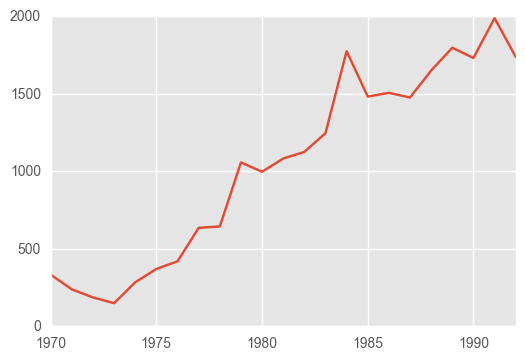

In [42]:
dfb_1993['iyear'].value_counts().sort_index().plot(kind='line')
#here's a terrible graph that gives you the average of 1992 and 1994 if you squint

In [43]:
#ignore the lass behind the curtain, etc. etc. 
# dfb_month = dfb[(dfb.iyear > 1985) & (dfb.iyear <= 2000)]

In [44]:
# y = dfb_month.groupby(['iyear', 'imonth']).eventid.count().reset_index()

In [45]:
#here's a dataset. Let's assume that all we're doing is taking the rolling mean (spoilers: that's all i'm doing)
#i'm going to use a large dataset first so I can look at trends as much as possible
dfb_1993 = dfb[(dfb.iyear > 1970) & (dfb.iyear <= 2000)]

In [46]:
X = dfb_1993['iyear'].value_counts().sort_index()

In [47]:
# y.head()

In [48]:
import datetime
from dateutil.relativedelta import relativedelta

import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller


/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()
/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).std()


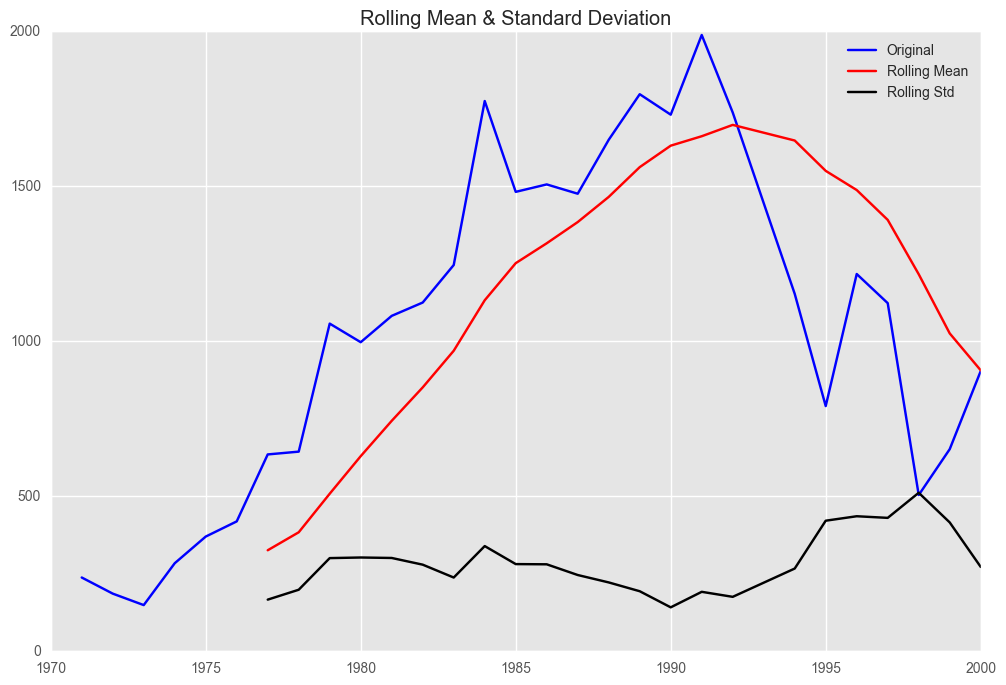

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=7,center=False).mean()


1971            NaN
1972            NaN
1973            NaN
1974            NaN
1975            NaN
1976            NaN
1977     325.857143
1978     383.857143
1979     508.285714
1980     629.428571
1981     743.428571
1982     851.285714
1983     969.428571
1984    1132.285714
1985    1252.000000
1986    1316.142857
1987    1384.571429
1988    1465.714286
1989    1561.714286
1990    1631.000000
1991    1661.428571
1992    1698.000000
1994    1647.571429
1995    1549.714286
1996    1487.857143
1997    1391.571429
1998    1216.285714
1999    1025.428571
2000     906.285714
Name: iyear, dtype: float64

In [49]:
def test_stationarity(timeseries, windownumber):

    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=windownumber)
    rolstd = pd.rolling_std(timeseries, window=windownumber)

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
#     print 'Results of Dickey-Fuller Test:'
#     dftest = adfuller(timeseries, autolag='AIC')
#     dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
#     for key,value in dftest[4].items():
#         dfoutput['Critical Value (%s)'%key] = value
#     print dfoutput 
    return pd.rolling_mean(timeseries, window=windownumber)

# perform test
test_stationarity(X, 7)

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()
/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).std()


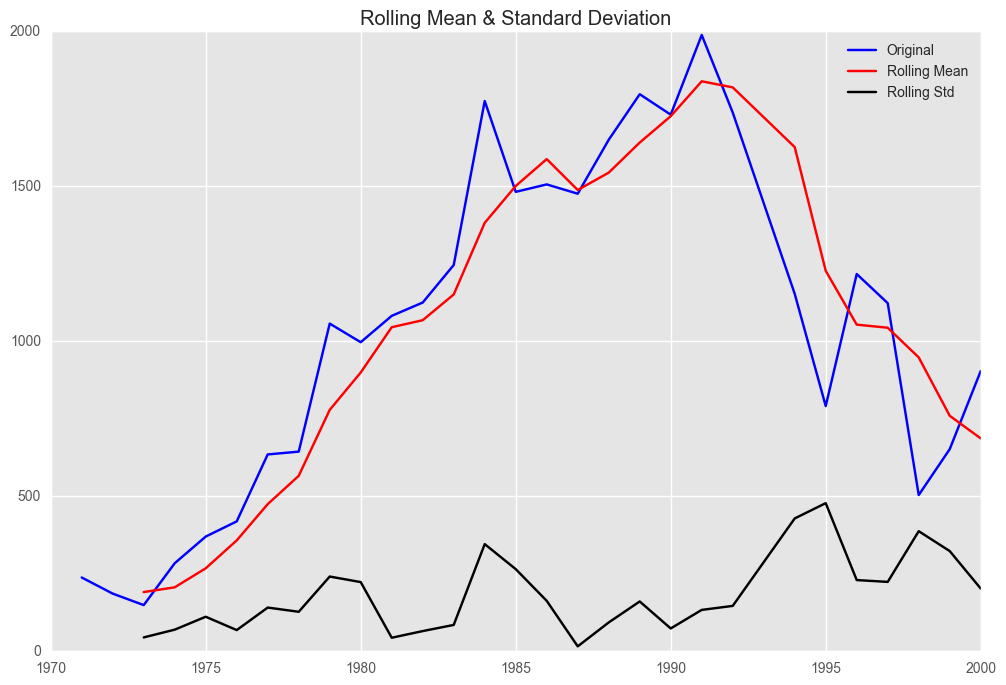

/Users/rb/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=3,center=False).mean()


1971            NaN
1972            NaN
1973     191.000000
1974     206.333333
1975     267.666667
1976     357.666667
1977     474.666667
1978     566.000000
1979     778.666667
1980     899.333333
1981    1045.333333
1982    1068.000000
1983    1151.000000
1984    1382.000000
1985    1501.000000
1986    1587.666667
1987    1488.000000
1988    1544.000000
1989    1641.000000
1990    1726.000000
1991    1838.666667
1992    1819.000000
1994    1626.333333
1995    1227.333333
1996    1053.666667
1997    1043.666667
1998     948.000000
1999     759.666667
2000     686.666667
Name: iyear, dtype: float64

In [50]:
test_stationarity(X, 3)

In [51]:
##based on this, let's take a simple average of the figures in 1992 and 1994:
print "1993 likely saw around", (1698+1647.5714)/2,"bombings"
# print "1993 likely saw around", (1819+1626.33)/2,"bombings"

1993 likely saw around 1672.7857 bombings


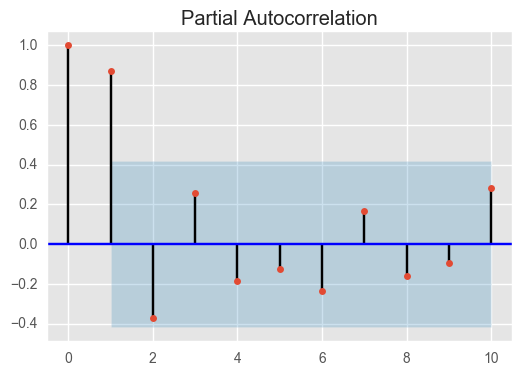

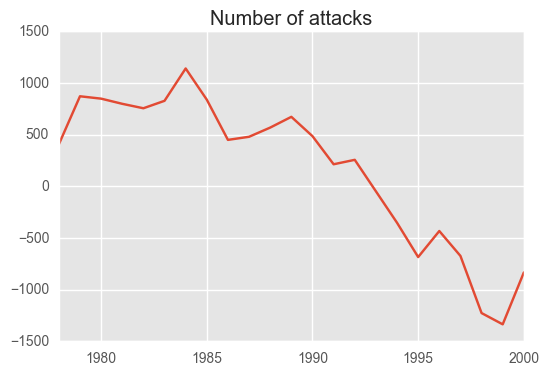

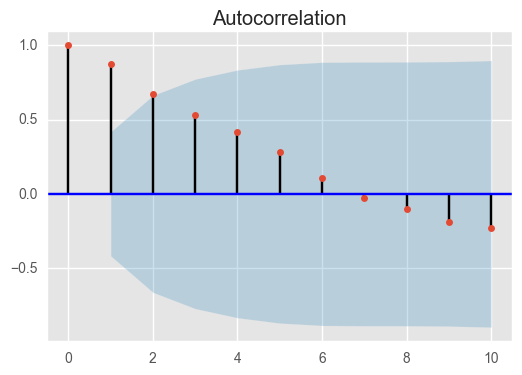

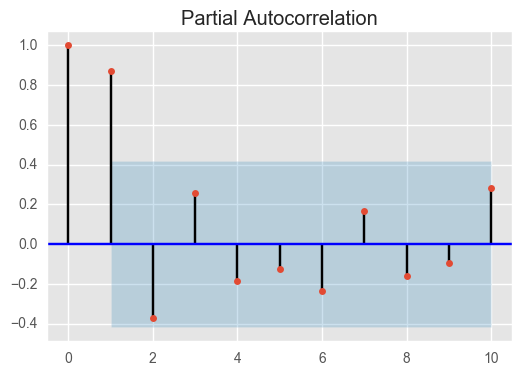

In [52]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Now to very quickly look at how autocorrelated these figures are to see how to adjust them in the future so that the 
#model reaches stationarity 

diff0 = X.diff(periods=7)[7:]
diff0.plot(title='Number of attacks')
plot_acf(diff0, lags=10)
plot_pacf(diff0, lags=10)

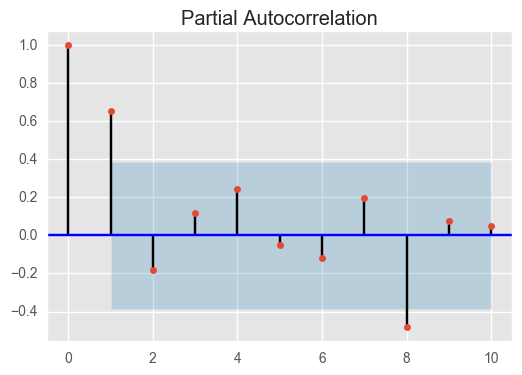

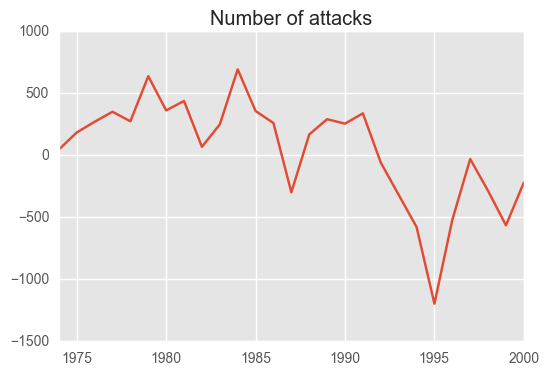

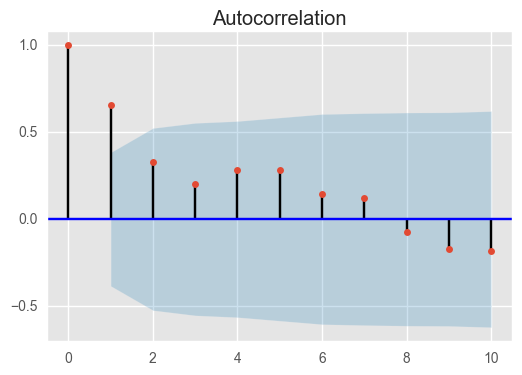

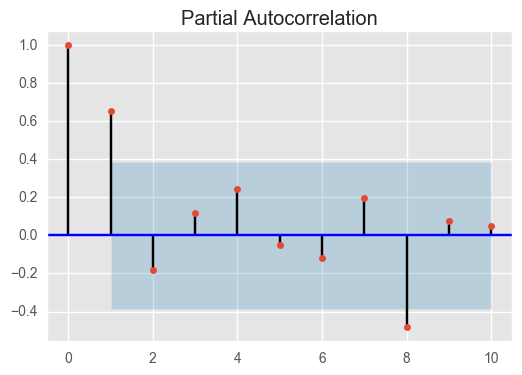

In [53]:
diff0 = X.diff(periods=3)[3:]
diff0.plot(title='Number of attacks')
plot_acf(diff0, lags=10)
plot_pacf(diff0, lags=10)

## Additional stuff for fun

In [54]:
dfb_1993['region_txt'].value_counts().sort_index()

Australasia & Oceania            65
Central America & Caribbean    3225
Central Asia                    130
East Asia                       237
Eastern Europe                  710
Middle East & North Africa     4074
North America                  1119
South America                  7849
South Asia                     2650
Southeast Asia                 1113
Sub-Saharan Africa             1786
Western Europe                 6961
Name: region_txt, dtype: int64

In [55]:
dfb_1993.groupby('iyear').region_txt.value_counts()

iyear  region_txt                 
1971   North America                  143
       Western Europe                  51
       Middle East & North Africa      36
       South America                    3
       Southeast Asia                   3
       Australasia & Oceania            1
       East Asia                        1
1972   Western Europe                 106
       North America                   40
       Middle East & North Africa      23
       South America                    8
       Central America & Caribbean      3
       Southeast Asia                   3
       Australasia & Oceania            2
       Eastern Europe                   1
1973   Western Europe                  88
       North America                   22
       South America                   22
       Middle East & North Africa      14
       Central America & Caribbean      1
       Eastern Europe                   1
       Southeast Asia                   1
1974   Western Europe                 125